In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import copy
import numpy as np
from scipy.integrate import trapz,simps
%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [2]:
from colossus.cosmology import cosmology

In [3]:
#look at documentation here: https://bdiemer.bitbucket.io/colossus/_static/tutorial_cosmology.html

In [4]:
cosmo = cosmology.setCosmology('planck15')
print(cosmo)

Cosmology "planck15" 
    flat = True, Om0 = 0.3089, Ode0 = 0.6910, Ob0 = 0.0486, H0 = 67.74, sigma8 = 0.8159, ns = 0.9667
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


In [5]:
cosmo.Om0, cosmo.Omde, cosmo.ns, cosmo.H0, cosmo.relspecies = 0.29, 0.71, 0.97, 70, False
#cosmo.OmbO = 0.02247
cosmo.checkForChangedCosmology()
print(cosmo)

Cosmology: Detected change in cosmological parameters.
Cosmology "planck15" 
    flat = True, Om0 = 0.2900, Ode0 = 0.7100, Ob0 = 0.0486, H0 = 70.00, sigma8 = 0.8159, ns = 0.9700
    de_model = lambda, relspecies = False, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


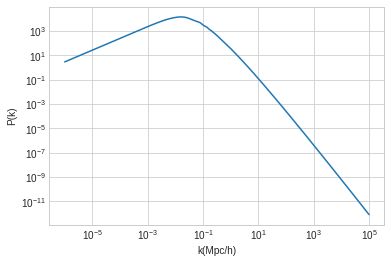

In [6]:
k = 10 ** np.linspace(-6, 5, 100000)
Pk = cosmo.matterPowerSpectrum(k, 0.57)

plt. figure()
plt.loglog()
plt.xlabel('k(Mpc/h)')
plt.ylabel('P(k)')
plt.plot(k, Pk, '-')
plt.show()

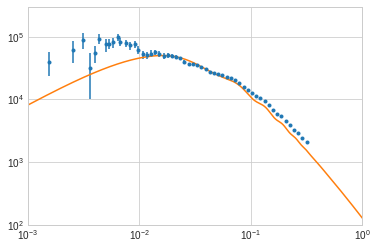

In [7]:
#Data and related paper here: http://www.sdss3.org/science/boss_publications.php

pk_cmasdr12 = np.loadtxt("/home/mimimustaine/Downloads/GilMarin_etal_2016ab_DR12CMASSLOWZ_powspec/GilMarin_boss_data/post-recon/cmass/GilMarin_2016_CMASSDR12_measurement_monopole_post_recon.txt").T
plt.figure()
plt.loglog()
plt.errorbar(pk_cmasdr12[0], pk_cmasdr12[1], yerr = pk_cmasdr12[2], fmt = '.')
plt.plot(k, 1.85 ** 2 * Pk, '-')
plt.xlim(1e-3, 1)
plt.ylim(100, 3e5)
plt.show()

In [8]:
cosmo = cosmology.setCosmology('planck15',)

def Pk_Om(k, Om_, b, z = 0.57):
    cosmo.Om0 = Om_
    return b ** 2 * cosmo.matterPowerSpectrum(k, z)

Esta es una prueba:

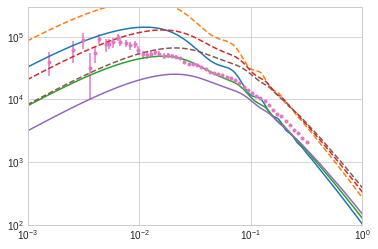

In [9]:
plt.figure()
plt.loglog()
OM = [0.2, 0.3, 0.4]

for om in OM:
    plt.plot(k, Pk_Om(k, om, 1.85), '-')
    plt.plot(k, Pk_Om(k, om, 3), '--')
    plt.xlim(1e-3, 1)
    plt.ylim(100, 3e5)
plt.errorbar(pk_cmasdr12[0], pk_cmasdr12[1], yerr = pk_cmasdr12[2], fmt = '.')
plt.show()

<strong>Implementando Monte-Carlo:</strong>

De forma similar a la función definida en la <strong>regresión lineal,</strong> se tiene lo siguiente:

Ideas:
    1. Tengo que comparar los datos obtenidos (del archivo .txt) puestos en un modelo tal como la línea model.
    2. Sigma también corresponde a los datos medidos.
    3. y es el real comparado con la predicción.

In [18]:
def likelihood(parametro, v):
    #Valores medidos:
    x, y, yerr = v[0], v[1], v[2]
    #Ahora el modelo, haciendo uso de x = k y parámetros:
    model = Pk_Om(x, parametro[0], parametro[1])
    #Comparación de medición con predicción:
    chisq = (y - model) ** 2 / yerr ** 2
    return - 0.5 * chisq.sum()
    
#def Pk_Om(k, Om_, b, z = 0.57):
#    cosmo.Om0 = Om_
#    return b ** 2 * cosmo.matterPowerSpectrum(k, z)

#El prior que se define a continuación como uniforme (también conocido como no informativo):
def prior(parametro):
    #Dos parámetros desconocidos:
    if 0.05 < parametro[0] < 1.0 and 0.05 < parametro[1] < 5.0:
        #Peso estadístico aleatorio (sugerido en clase):
        return 0.0
    return - np.inf

def ejecucion(parametro, v):
    prior_ = prior(parametro)
    if not np.isfinite(prior_):
        return - np.inf
    return likelihood([om_aux, b_aux], [pk_cmasdr12[0], pk_cmasdr12[1], pk_cmasdr12[2]]) + prior_

In [27]:
#Número de iteraciones por cada camino:
N = 10000
#Número de caminos (j):
caminos = 3
#Desviación estándar para determinar a, b iniciales:
sigma = 0.1
#Arreglos en los que se guardarán los valores iniciales de om, b, lh (igual al número de caminos):
om_inicial = []
b_inicial = []
lh_inicial = []

#Valor inicial de parámetros (a, b, lh):
for i in range(caminos):
    om_inicial.append(np.random.uniform(0.05, 0.99))
    b_inicial.append(np.random.uniform(0.05, 5))
    #Valor inicial del likelihood:
    lh_inicial.append(likelihood([om_inicial[i], b_inicial[i]], [pk_cmasdr12[0], pk_cmasdr12[1], pk_cmasdr12[2]]))

#Arreglos donde se guardarán los valores de a, b, likelihood (resultado):
om = []
b = []
lh = []

#Se guardan los primeros valores propuestos:
for i in range(caminos):
    om.append([om_inicial[i]])
    b.append([b_inicial[i]])
    lh.append([lh_inicial[i]])

In [28]:
#Contador para guardar en lugar indicado resutado para arreglos a, b, lh:
k = 0
#Razón de aceptación para cada uno de los caminos:
acep = []

#El algoritmo se repite para cada camino:
for j in range(caminos):
    #Para cada camino, se agrega una posición de razón de aceptación:
    acep.append(0)
    for i in range(N - 1):
        #Se generan dos valores random, no importa la distribución en rango [0,10].
        om_aux = np.random.normal(om[j][k], sigma)
        b_aux = np.random.normal(b[j][k], sigma)
        
        #En la función siguiente se prueba el prior y se establece el valor para lh_aux:
        lh_aux = ejecucion([om_aux, b_aux], [pk_cmasdr12[0], pk_cmasdr12[1], pk_cmasdr12[2]])
        
        #Condición de likelihood:
        if lh_aux > lh_inicial[j]:
            #Si se cumple la condición, se agregan a, b y se actualiza el valor del likelihood.
            om[j].append(om_aux)
            b[j].append(b_aux)
            lh[j].append(lh_aux)
            lh_inicial[j] = lh_aux
            k += 1
            acep[j] += 1
        else:
            #Si no, hay una segunda oportunidad para aceptar el valor:
            comparador = - np.log(np.random.uniform(0,1))
            #Si se cumple que la resta sea menor al comparador (segunda oportunidad):
            if (lh_aux - lh_inicial[j]) > comparador:
                om[j].append(om_aux)
                b[j].append(b_aux)
                lh[j].append(lh_aux)
                lh_inicial[j] = lh_aux
                k += 1
                acep[j] += 1
            #Si no, se agrega valor anterior de a, b y se añade valor de lh:
            else:
                om[j].append(om[j][i - 1])
                b[j].append(b[j][i - 1])
                lh[j].append(lh_inicial[j])
                k += 1
    k = 0

#---------Aceptación---------#
for i in range(caminos):
    acep[i] /= N
acep

[0.0032, 0.0011, 0.0022]

In [29]:
#El mínimo chi square está en:
parametros = []
for i in range(caminos):
    parametros.append(np.where(lh[i] == np.min(lh[i])))

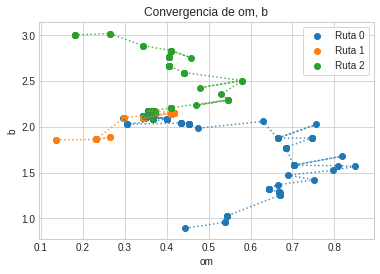

In [30]:
plt.title('Convergencia de om, b')
for i in range(caminos):
    plt.scatter(om[i], b[i], label = 'Ruta {0}'.format(i))
    plt.plot(om[i], b[i], linestyle = ':', alpha = 0.8)
    plt.ylabel('b')
    plt.xlabel('om')
    plt.legend(frameon = True)
plt.show()

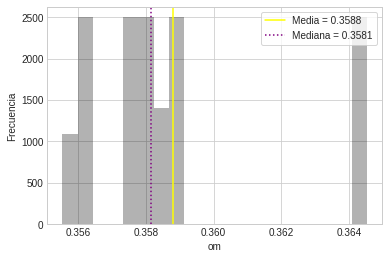

In [31]:
om_total = []

for i in range(caminos):
    for j in range(np.int(len(om[i]) / 2), len(om[i])):
        om_total.append(om[i][j])
plt.hist(om_total, 20, color = 'black', alpha = 0.3)
#plt.axvline(a_0, color = 'red', label = 'Real = {0}'.format(a_0))
plt.axvline(np.mean(om_total), color = 'yellow', label = 'Media = {0}'.format(np.round(np.mean(om_total), 4)))
plt.axvline(np.median(om_total), color = 'purple', linestyle = ':', label = 'Mediana = {0}'.format(np.round(np.median(om_total), 4)))
plt.xlabel('om')
plt.ylabel('Frecuencia')
plt.legend(frameon = True)
plt.show()

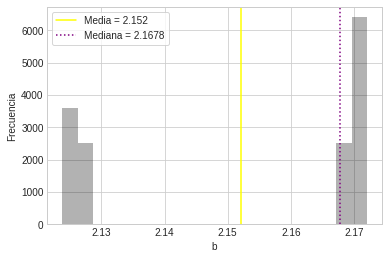

In [32]:
b_total = []

for i in range(caminos):
    for j in range(np.int(len(b[i]) / 2), len(b[i])):
        b_total.append(b[i][j])
plt.hist(b_total, 20, color = 'black', alpha = 0.3)
#plt.axvline(b_0, color = 'red', label = 'Real = {0}'.format(b_0))
plt.axvline(np.mean(b_total), color = 'yellow', label = 'Media = {0}'.format(np.round(np.mean(b_total), 4)))
plt.axvline(np.median(b_total), color = 'purple', linestyle = ':', label = 'Mediana = {0}'.format(np.round(np.median(b_total), 4)))
plt.xlabel('b')
plt.ylabel('Frecuencia')
plt.legend(frameon = True)
plt.show()

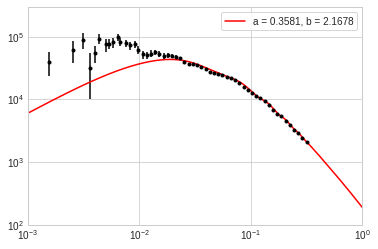

In [33]:
k = 10 ** np.linspace(-6, 5, 100000)
plt.figure()
plt.loglog()
plt.errorbar(pk_cmasdr12[0], pk_cmasdr12[1], yerr = pk_cmasdr12[2], fmt='.', color = 'black')
plt.plot(k, Pk_Om(k, np.mean(om_total), np.mean(b_total)), color = 'red', label = 'a = {0}, b = {1}'.format(np.round(np.median(om_total), 4), np.round(np.median(b_total), 4)))
plt.legend(frameon = True)
plt.xlim(1e-3, 1)
plt.ylim(100, 3e5)
plt.show()

### Modificación al modelo, se agrega un nuevo parámetro <strong>beta.</strong>

In [63]:
def Pk_Om(k, Om_, b, beta, z = 0.57):
    cosmo.Om0 = Om_
    return b ** 2 * (1 + beta) * cosmo.matterPowerSpectrum(k, z)

def chisq_n(parametro, v):
    #Valores medidos:
    x, y, yerr = v[0], v[1], v[2]
    #Ahora el modelo, haciendo uso de x = k y parámetros:
    model = Pk_Om(x, parametro[0], parametro[1], parametro[2])
    #Comparación de medición con predicción:
    chisq = (y - model) ** 2 / yerr ** 2
    return chisq.sum()
    
#def Pk_Om(k, Om_, b, z = 0.57):
#    cosmo.Om0 = Om_
#    return b ** 2 * cosmo.matterPowerSpectrum(k, z)

#El prior que se define a continuación como uniforme (también conocido como no informativo):
def prior(parametro):
    #Dos parámetros desconocidos:
    if 0.05 < parametro[0] < 1.0 and 0.05 < parametro[1] < 5.0 and 0.05 < parametro[2] < 5.0:
        #Peso estadístico aleatorio (sugerido en clase):
        return 0.0
    return - np.inf